# 06 - Summarization

## The CNN/DailyMail Dataset

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("cnn_dailymail", version="3.0.0")
print(f"Features: {dataset['train'].column_names}")

Found cached dataset cnn_dailymail (/home/tobi/.cache/huggingface/datasets/cnn_dailymail/default/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

Features: ['article', 'highlights', 'id']


In [3]:
idx = 40767
sample = dataset["train"][40767]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample['article'])}):
""")
print(sample["article"][:500])
print(f"\nSummary (length: {len(sample['highlights'])}):")
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 3192):

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n

Summary (length: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


## Text Summarization Pipelines

In [4]:
sample_text = dataset["train"][idx]["article"][:2000]
summaries = {}

In [5]:
import nltk
from nltk.tokenize import sent_tokenize

In [6]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/tobi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### Summarization Baseline

In [8]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [9]:
summaries["baseline"] = three_sentence_summary(sample_text)
print(summaries["baseline"])

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.


### GPT-2

In [10]:
from transformers import pipeline, set_seed

In [11]:
set_seed(42)
pipe = pipeline("text-generation", model="gpt2")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query):])
)
print(summaries["gpt2"])

/home/tobi/miniconda3/envs/nlp/lib/python3.9/site-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Usain Bolt triumphed after a difficult final, but then he got into trouble when Canada made him try to block.
It's the last match he's held all of last year with the men, who were later picked in the third and fourth rounds of the men's 100m and 200m and at Rio-Gold.
UPDATE - November 8 - Team USA won in 36.36,


### T5

In [12]:
pipe = pipeline("summarization", model="t5-base")
pipe_out = pipe(sample_text)
pipe_out

/home/tobi/miniconda3/envs/nlp/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


[{'summary_text': 'usain bolt wins third gold medal at world championships . anchors Jamaica to victory in 4x100m relay . anchored by shelly-Ann Fraser-Pryce who completes triple . world champions the united states finish second .'}]

In [13]:
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))
print(summaries["t5"])

usain bolt wins third gold medal at world championships .
anchors Jamaica to victory in 4x100m relay .
anchored by shelly-Ann Fraser-Pryce who completes triple .
world champions the united states finish second .


### BART

In [14]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
pipe_out

[{'summary_text': "Usain Bolt wins his third gold of the world championships in Moscow. Bolt anchors Jamaica to victory in the men's 4x100m relay. The 26-year-old has now won eight gold medals at world championships. Jamaica's women also win gold in the relay, beating France in the process."}]

In [15]:
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))
print(summaries["bart"])

Usain Bolt wins his third gold of the world championships in Moscow.
Bolt anchors Jamaica to victory in the men's 4x100m relay.
The 26-year-old has now won eight gold medals at world championships.
Jamaica's women also win gold in the relay, beating France in the process.


### PEGASUS

In [16]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
pipe_out

[{'summary_text': "Usain Bolt wins third gold of world championships .<n>Anchors Jamaica to victory in men's 4x100m relay .<n>Eighth gold at the championships for Bolt .<n>Jamaica also win women's 4x100m relay ."}]

In [17]:
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")
print(summaries["pegasus"])

Usain Bolt wins third gold of world championships.
Anchors Jamaica to victory in men's 4x100m relay.
Eighth gold at the championships for Bolt.
Jamaica also win women's 4x100m relay .


## Comparing Different Summaries

In [18]:
print("GROUND TRUTH")
print(dataset["train"][idx]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.

GPT2
Usain Bolt triumphed after a difficult final, but then he got into trouble when Canada made him try to block.
It's the last match he's held all of last year with the men, who were later picked in the third and fourth rounds of the men's 100m and 200m and at Rio-Gold.
UPDATE - November 8 - Team USA won in 36.36,

T5

## Measuring the Quality of Generated Text

### BLEU
- https://cloud.google.com/translate/automl/docs/evaluate
- https://towardsdatascience.com/evaluating-text-output-in-nlp-bleu-at-your-own-risk-e8609665a213

In [19]:
from datasets import load_metric

In [20]:
bleu_metric = load_metric("sacrebleu")
bleu_metric

/tmp/ipykernel_6188/883247576.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions (`list` of `str`): list of translations to score. Each translation should be tokenized into a list of tokens.
    references (`list` of `list` of `str`): A list of lists of references. The contents of the first sub-list are the references for the first prediction, the contents of the second sub-list are for the second prediction, etc. Note that there must be the same number of references for each prediction (i.e. all sub-lists must be of the same length).
    smooth_method (`str`): The smoothing method to use, defaults to `'exp'`. Possible values are:
        - `'none'`: no smoothing
        - `'floor'`: increment zero counts
        - `'add-k'`: increment num/deno

In [21]:
import pandas as pd
import numpy as np

In [22]:
bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [23]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"]
)
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROGUE
- https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460

In [24]:
rouge_metric = load_metric("rouge")
rouge_metric

Metric(name: "rouge", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')}, usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLSum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
    use_aggregator: Return aggregates if this is set to True
Retu

In [25]:
rouge_metric.add(prediction="the cat is on mat", reference=["the cat is on the mat"])
rouge_metric.compute()

{'rouge1': AggregateScore(low=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), mid=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), high=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091)),
 'rouge2': AggregateScore(low=Score(precision=0.75, recall=0.6, fmeasure=0.6666666666666665), mid=Score(precision=0.75, recall=0.6, fmeasure=0.6666666666666665), high=Score(precision=0.75, recall=0.6, fmeasure=0.6666666666666665)),
 'rougeL': AggregateScore(low=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), mid=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), high=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091)),
 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), mid=Score(precision=1.0, recall=0.8333333333333334, fmeasure=0.9090909090909091), high=Score(precision=1.0, r

In [26]:
reference = dataset["train"][idx]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [27]:
for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.212766,0.021739,0.127660,0.148936
t5,0.524590,0.237288,0.426230,0.491803
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


## Evaluating PEGASUS on the CNN/DailyMail Dataset

In [28]:
def evaluate_summaries_baseline(
    dataset, metric, column_text="article", column_summary="highlights"
):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score

In [29]:
text_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

In [30]:
score = evaluate_summaries_baseline(text_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


In [31]:
from tqdm import tqdm
import torch

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

In [34]:
def evaluate_summaries_pegasus(
    dataset,
    metric,
    model,
    tokenizer,
    batch_size=16,
    device=device,
    column_text="article",
    column_summary="highlights",
):
    article_batches = list(chunks(dataset[column_text], batch_size))
    summaries_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, summaries_batches), total=len(article_batches)
    ):
        inputs = tokenizer(
            article_batch,
            max_length=1024,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        summaries = model.generate(
            inputs=inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device),
            length_penalty=0.8,
            num_beams=8,
            max_length=128,
        )
        decoded_summaries = [
            tokenizer.decode(
                s, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            for s in summaries
        ]
        decoded_summaries = [d.replace("\n", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
    score = metric.compute()
    return score


In [35]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [36]:
model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [37]:
i = 1
article, summary_solution = dataset["test"][i]["article"], dataset["test"][i]["highlights"]
print(article)
t = tokenizer(dataset["test"][1]["article"], return_tensors="pt")
print(t)
t = model.generate(t["input_ids"].to(device))
print(t)
summary = tokenizer.decode(t[0], clean_up_tokenization_spaces=True, skip_special_tokens=True)
print(summary)
print(summary_solution)

(CNN)Never mind cats having nine lives. A stray pooch in Washington State has used up at least three of her own after being hit by a car, apparently whacked on the head with a hammer in a misguided mercy killing and then buried in a field -- only to survive. That's according to Washington State University, where the dog -- a friendly white-and-black bully breed mix now named Theia -- has been receiving care at the Veterinary Teaching Hospital. Four days after her apparent death, the dog managed to stagger to a nearby farm, dirt-covered and emaciated, where she was found by a worker who took her to a vet for help. She was taken in by Moses Lake, Washington, resident Sara Mellado. "Considering everything that she's been through, she's incredibly gentle and loving," Mellado said, according to WSU News. "She's a true miracle dog and she deserves a good life." Theia is only one year old but the dog's brush with death did not leave her unscathed. She suffered a dislocated jaw, leg injuries a

/home/tobi/miniconda3/envs/nlp/lib/python3.9/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 128 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[    0,   139,  2396,   108,   114,   695,   121,   526,   121, 10572,
         25802,  8539,  1707,   108,   140,  5175,  1194,   141,   114,   439,
           111,  8056,   115,   114,   764,   110,   107,   106, 14093,   390,
           678,   108,   109,  1296, 79282,   116,   112,   114,  2741,   111,
           117,   784,   115,   141,   114,  5631,   110,   107,   106,  2239,
           397,  2446,   112,  2374,   114, 74919,  5487,   111,   114,  8665,
           252,   121,   386, 23697, 17954,   110,   107,     1]],
       device='cuda:0')
Theia, a white-and-black bully breed mix, was apparently hit by a car and buried in a field.<n>Four days later, the dog staggers to a farm and is taken in by a worker.<n>She needs surgery to fix a dislocated jaw and a caved-in sinus cavity.
Theia, a bully breed mix, was apparently hit by a car, whacked with a hammer and buried in a field .
"She's a true miracle dog and she deserves a good life," says Sara Mellado, who is looking fo

In [38]:
score = evaluate_summaries_pegasus(text_sampled, rouge_metric, model, tokenizer, batch_size=4)

  0%|                                                                                                                                                               | 0/250 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 5.26 GiB already allocated; 0 bytes free; 5.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, index=["pegasus"])

## Training a Summarization Model

In [40]:
dataset_samsum = load_dataset("samsum")
split_lenghts = [len(dataset_samsum[split]) for split in dataset_samsum]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /home/tobi/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [41]:
print(f"Split lengths: {split_lenghts}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### Evaluating PEGASUS on SAMSum

In [42]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
pipe_out

Your max_length is set to 128, but you input_length is only 122. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]

In [43]:
print("Summary:")
print(pipe_out[0]["summary_text"].replace(".<n>", ".\n"))

Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together .
Hannah: I'd rather you texted him .
Amanda: Just text him .


In [44]:
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=8
)

  0%|                                                                                                                                                               | 0/103 [00:05<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 6.00 GiB total capacity; 5.38 GiB already allocated; 0 bytes free; 5.39 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [45]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, index=["pegasus"])

TypeError: from_dict() got an unexpected keyword argument 'index'

### Fine-Tuning PEGASUS

In [47]:
import matplotlib.pyplot as plt

In [48]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


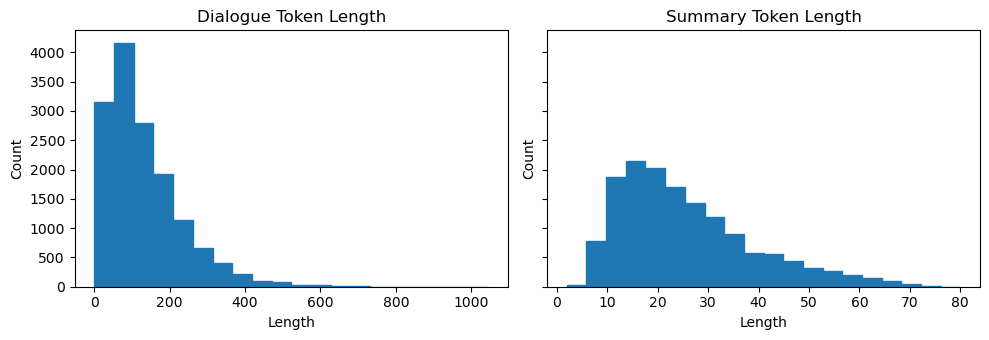

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
axes[1].set_ylabel("Count")
plt.tight_layout()
plt.show()

In [50]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    }

In [62]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)
dataset_samsum_pt

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

/home/tobi/miniconda3/envs/nlp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [55]:
from transformers import DataCollatorForSeq2Seq

In [56]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [57]:
from transformers import TrainingArguments, Trainer

In [60]:
training_args = TrainingArguments(
    output_dir="pegasus-samsum",
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=False,
    evaluation_strategy="epoch",
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16,
)
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=500,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=16,
gradient_checkpointing=False,
greater_is_better=None,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_n

In [64]:
trainer = Trainer(
    model=model, 
    args=training_args, 
    tokenizer=tokenizer, 
    data_collator=seq2seq_data_collator,
    train_dataset=dataset_samsum_pt["train"],
    eval_dataset=dataset_samsum_pt["validation"],
)
trainer

In [65]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `PegasusForConditionalGeneration.forward` and have been ignored: dialogue, id, summary. If dialogue, id, summary are not expected by `PegasusForConditionalGeneration.forward`,  you can safely ignore this message.
/home/tobi/miniconda3/envs/nlp/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 14732
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 16
  Total optimization steps = 920
  Number of trainable parameters = 568699904
You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokeni

OutOfMemoryError: CUDA out of memory. Tried to allocate 376.00 MiB (GPU 0; 6.00 GiB total capacity; 4.74 GiB already allocated; 0 bytes free; 5.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [66]:
evaluate_summaries_pegasus(
    dataset_samsum["test"],
    rouge_metric,
    trainer.model,
    tokenizer,
    batch_size=2,
    column_text="dialogue",
    column_summary="summary",
)
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, index=["pegasus"])

  0%|                                                                                                                                                               | 0/410 [00:00<?, ?it/s]Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "max_length": 128,
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

  0%|                                                                                                                                                               | 0/410 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 6.00 GiB total capacity; 5.19 GiB already allocated; 0 bytes free; 5.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### Generating Dialogue Summaries

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams": 8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

loading configuration file config.json from cache at /home/tobi/.cache/huggingface/hub/models--transformersbook--pegasus-samsum/snapshots/f00170164d55821831b9396cc3da176af59f30ec/config.json
Model config PegasusConfig {
  "_name_or_path": "transformersbook/pegasus-samsum",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 1,
  "forced_eos_token_id": 1,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "

loading weights file pytorch_model.bin from cache at /home/tobi/.cache/huggingface/hub/models--transformersbook--pegasus-samsum/snapshots/f00170164d55821831b9396cc3da176af59f30ec/pytorch_model.bin
Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "forced_eos_token_id": 1,
  "length_penalty": 0.8,
  "max_length": 128,
  "min_length": 32,
  "num_beams": 8,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



In [ ]:
print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])